In [1]:
#import modules
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims
import trackpy as tp
import os

#MatPlotLib
import matplotlib as mpl
import matplotlib.pyplot as plt

#Scikit-image
from skimage.transform import rotate
from skimage.util import crop
from skimage import exposure
from skimage import data, img_as_float, img_as_uint

#magic commands
%matplotlib inline 
%matplotlib notebook

#tweak styles
mpl.rc('figure', figsize = (10,6))
mpl.rc('image', cmap = 'gray')

#get some DeprecationWarnings in sklearn module. Ignore these warnings for now.
import warnings
warnings.filterwarnings('ignore')

SUPPORT FUNCTIONS

In [128]:
def adapthist(im):
    """
    Enhance contrast by adaptive histogram equalization
    """
    
    im_adapteq = exposure.equalize_adapthist(im, clip_limit=0.01)
    
    return im_adapteq

def showim2(im1, im2):
    """
    Show two images side-by-side
    """
    #Show images
    f, ax = plt.subplots(1, 2, sharey=True)
    plt.axes(ax[0])
    plt.imshow(im1)
    plt.axes(ax[1])
    plt.imshow(im2)
    
def partparms(trajectory):
    """
    IN: trajs OUT: np.array(particle#, diag_size, total_dist, mean_vel)
    """
    #store particle numbers
    partnumbers = trajectory['particle'].unique()
    
    #create empty output array
    p_partparms = np.array([[],[],[],[]]).T
    
    for p in partnumbers:
        
        #filter single particle trajectory and sort by frame number
        trajectory_p = pd.DataFrame(trajectory[trajectory['particle'] == p].sort_values(['frame'], ascending=True))

        #create empty 2-d arry for each particle with [distance,velocity]
        dist_vel = np.array([[],[]]).T
        
        for obs in range(1,len(trajectory_p)):
        
            r0 = np.array([trajectory_p['x'][obs-1], trajectory_p['y'][obs-1]])
            r1 = np.array([trajectory_p['x'][obs], trajectory_p['y'][obs]])
            t = trajectory_p['frame'][obs] - trajectory_p['frame'][obs-1]
            dist = np.linalg.norm(r1-r0)
            vel = dist/t
            dist_vel = np.append(dist_vel,[[dist,vel]], axis = 0)

        #calculate trajectory parameters for each particle
        total_dist = np.sum(dist_vel, axis = 0)[0]
        mean_vel = np.mean(dist_vel, axis =0)[1]
        diag_size = tp.diagonal_size(trajectory_p)
        
        p_partparms = np.append(p_partparms, [[p, diag_size, total_dist, mean_vel]], axis=0)
        
    print('Extracted ',p_partparms.shape[0] ,'trajectories.')    
    return(p_partparms)


In [130]:
trajectory = trajsF1.copy()
#store particle numbers
partnumbers = trajectory['particle'].unique()
    
#create empty output array
p_partparms = np.array([[],[],[],[]]).T
    
for p in partnumbers:
        
    #filter single particle trajectory and sort by frame number
    trajectory_p = pd.DataFrame(trajectory[trajectory['particle'] == p].sort_values(['frame'], ascending=True))

    #create empty 2-d arry for each particle with [distance,velocity]
    dist_vel = np.array([[],[]]).T
        
    for obs in range(1,len(trajectory_p)):
        
        #here is the problem: some lines (e.g. obs=3 for p=4 do not exist)
        r0 = np.array([trajectory_p['x'][obs-1], trajectory_p['y'][obs-1]])
        r1 = np.array([trajectory_p['x'][obs], trajectory_p['y'][obs]])
        t = trajectory_p['frame'][obs] - trajectory_p['frame'][obs-1]
        dist = np.linalg.norm(r1-r0)
        vel = dist/t
        dist_vel = np.append(dist_vel,[[dist,vel]], axis = 0)

    #calculate trajectory parameters for each particle
    total_dist = np.sum(dist_vel, axis = 0)[0]
    mean_vel = np.mean(dist_vel, axis =0)[1]
    diag_size = tp.diagonal_size(trajectory_p)
        
    p_partparms = np.append(p_partparms, [[p, diag_size, total_dist, mean_vel]], axis=0)
        
print('Extracted ',p_partparms.shape[0] ,'trajectories.')    


KeyError: 3

In [166]:
#trajectory_p = pd.DataFrame(trajectory[trajectory['particle'] == p].sort_values(['frame'], ascending=True))
#r0 = np.array([trajectory_p['x'][obs-1], trajectory_p['y'][obs-1]])
#r1 = np.array([trajectory_p['x'][obs], trajectory_p['y'][obs]])
#t = trajectory_p['frame'][obs] - trajectory_p['frame'][obs-1]
#dist = np.linalg.norm(r1-r0)
#vel = dist/t
#dist_vel = np.append(dist_vel,[[dist,vel]], axis = 0)
#trajectory_p['x']
p

4.0

Data file and path information

In [67]:
filedir = os.getcwd() + '\\BLOODFLOWDATA'
resultsdir = os.getcwd() + '\\RESULTS'
filename = 'H160122-X10-TAILEND3-FL80FPS.tif'
file = os.path.join(filedir, filename)
#frames = pims.TiffStack(file)
frames = pims.TiffStack(file, process_func=adapthist)
#metadata
metadata = frames[0].metadata['ImageDescription']

In [70]:
print(metadata)

<MetaData>
<prop id="Description" type="string" value="Acquired from AndorSdk3 Camera&#13;&#10;Exposure: 5 msec&#13;&#10;Binning: 1 X 1&#13;&#10;Region: 256 x 216, offset at (0, 0)&#13;&#10;Digitizer: 200 MHz - lowest noise&#13;&#10;Gain: 11-bit (high well capacity)&#13;&#10;Cooler On: 1&#13;&#10;Camera State: Non-Overlapped&#13;&#10;"/>
<prop id="MetaDataVersion" type="float" value="1"/>
<prop id="ApplicationName" type="string" value="MetaMorph"/>
<prop id="ApplicationVersion" type="string" value="7.8.10.0"/>
<PlaneInfo>
<prop id="plane-type" type="string" value="plane"/>
<prop id="pixel-size-x" type="int" value="256"/>
<prop id="pixel-size-y" type="int" value="216"/>
<prop id="bits-per-pixel" type="int" value="16"/>
<prop id="autoscale-state" type="bool" value="off"/>
<prop id="autoscale-min-percent" type="float" value="0"/>
<prop id="autoscale-max-percent" type="float" value="0"/>
<prop id="scale-min" type="int" value="100"/>
<prop id="scale-max" type="int" value="402"/>
<prop id="s

Calibrations

In [109]:
print('Pixel calibration for Andor Neo sCMOS 2560 x 2160 camera')
print('Image file: ', filename)
objective_magnification = 10
sideport_magnification = 0.38
chip_size_x = 16.6 #full frame chip size X [mm]
chip_size_y = 14.0 #full frame chip size Y [mm]
chip_pixels_x = 2560 #full frame chip size X [pixels]
chip_pixels_y = 2160 #full frame chip size Y [pixels]
field_ratio_x = frames[0].shape[1] / chip_pixels_x
field_ratio_y = frames[0].shape[0] / chip_pixels_y
field_size_x = chip_size_x * field_ratio_x / objective_magnification / sideport_magnification
field_size_y = chip_size_y * field_ratio_y / objective_magnification / sideport_magnification
pixel_calibration_x = chip_size_x * 1000 / chip_pixels_x / objective_magnification / sideport_magnification
pixel_calibration_y = chip_size_y * 1000 / chip_pixels_y / objective_magnification / sideport_magnification
pixel_calibration = np.mean([pixel_calibration_x, pixel_calibration_y]) #mean value to convert pixels into microns
print('pixel_calibration_x = ', '%.3f' % pixel_calibration_x, '[um/pixel]')
print('pixel_calibration_y = ', '%.3f' % pixel_calibration_y, '[um/pixel]')
print('field_size_x = ', '%.2f' % field_size_x, '[mm]')
print('field_size_y = ', '%.2f' % field_size_y, '[mm]')

Pixel calibration for Andor Neo sCMOS 2560 x 2160 camera
Image file:  H160122-X10-TAILEND3-FL80FPS.tif
pixel_calibration_x =  1.706 [um/pixel]
pixel_calibration_y =  1.706 [um/pixel]
field_size_x =  0.44 [mm]
field_size_y =  0.37 [mm]


1.7064144736842104

LOCATE FEATURES

<IPython.core.display.Javascript object>


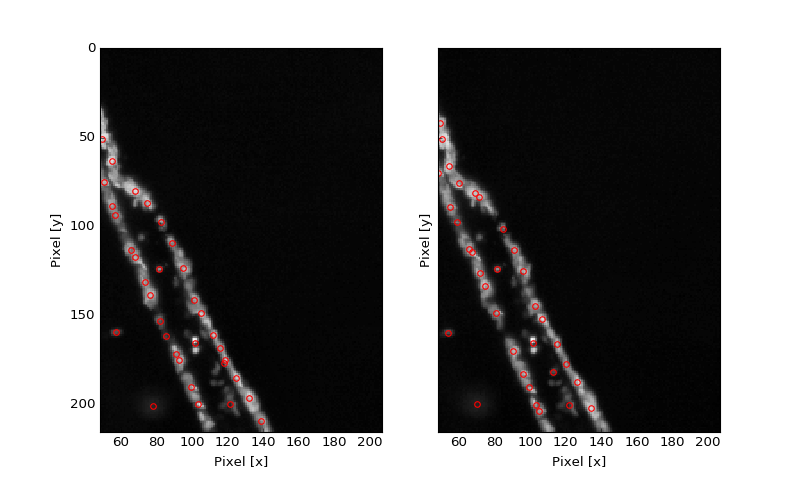

[None, None]

In [8]:
#Locate features
fnumber = 50 #current frame to look at
diam = 11 #odd integer with features extent in pixels
minm = 0.03 #minimum integrated brightness
sep = 1 #minimum separation between features
perc = 20 #features must have a peak brighter than pixels in this percentile
topnum = 500 #return only the N brightest features above minmass

feats1 = tp.locate(frames[fnumber], invert=False, diameter=diam, minmass=minm, separation=sep, percentile=perc,
                  topn=topnum)
feats2 = tp.locate(frames[fnumber+10], invert=False, diameter=diam, minmass=minm, separation=sep, percentile=perc,
                  topn=topnum)

f, ax = plt.subplots(1, 2, sharey=True)
plt.axes(ax[0])
tp.annotate(feats1, frames[fnumber], plot_style={'markersize':5, 'markeredgewidth':1})

plt.axes(ax[1])
tp.annotate(feats2, frames[fnumber+10], plot_style={'markersize':5, 'markeredgewidth':1})

#set axis properties
[ax[i].set_xlabel('Pixel [x]') for i in range(2)]
[ax[i].set_ylabel('Pixel [y]') for i in range(2)]
[ax[i].legend_.remove() for i in range(2)]

FIND FEATURES IN ALL FRAMES

In [9]:
feats = tp.batch(frames, diameter=diam, minmass=minm, separation=sep, invert=False, percentile=perc,
                 topn=topnum)

Frame 499: 49 features


LINK FEATURES INTO PARTICLE TRAJECTORIES

In [10]:
searchrange = 5 #Maximum distance features can move between frames
memory = 3 #Maximum number of frames during which a feature can vanish, than reappear and consider the same particle
trajs = tp.link_df(feats, 5, memory=3)

Frame 499: 49 trajectories present


FILTER TRAJECTORIES

In [11]:
#get rid of spurious trajectories (minimum number of frames)
trajsF1 = tp.filter_stubs(trajs, threshold = 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', trajs['particle'].nunique())
print('After:', trajsF1['particle'].nunique())

Before: 1010
After: 530


In [12]:
trajsF1[1:10]

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
1,26.332351,16.466256,8.813402,3.228737,0.290789,0.254914,21.303722,0.007254,1,2
2,27.459324,15.640343,9.840865,3.137470,0.232393,0.290263,23.086704,0.006823,2,2
3,27.900578,15.967861,9.846473,3.069560,0.215937,0.289133,23.770860,0.006414,3,2
4,28.500000,16.219578,10.471633,3.135576,0.119873,0.268021,25.421876,0.005991,4,2
5,28.421253,17.368211,13.439323,3.331357,0.078690,0.398995,30.253437,0.005743,5,2
6,28.419610,17.566450,14.910281,3.387999,0.111252,0.408598,31.799975,0.005244,6,2
7,27.633291,17.400366,17.018545,3.350379,0.185286,0.402636,34.614140,0.004755,7,2
8,27.605669,16.845930,16.834854,3.251855,0.164614,0.393955,34.551321,0.004667,8,2
9,27.793862,16.047488,16.101882,3.142005,0.111307,0.373719,33.837448,0.004898,9,2


In [35]:
filename

'H160122-X10-TAILEND3-FL80FPS.tif'

<IPython.core.display.Javascript object>


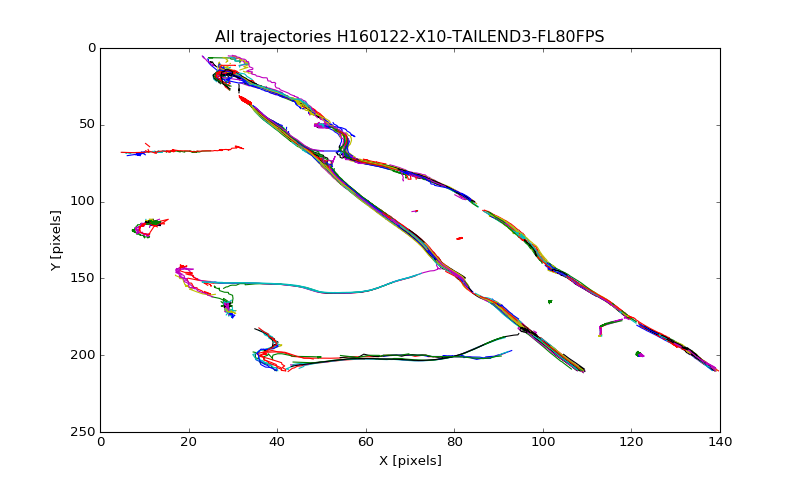

In [36]:
#plot trajectories
plt.figure('Raw particle trajectories')
ax0=plt.axes()
plt.axes(ax0)
tp.plot_traj(trajsF1)
plt.gca().legend_.remove()
ax0.set_xlabel('X [pixels]')
ax0.set_ylabel('Y [pixels]')
ax0.invert_yaxis()
ax0.set_title('All trajectories ' + filename[:-4])
#save image
sname = resultsdir + '\\' + filename[:-4] + 'Traj.png'
plt.savefig(sname)

In [129]:
#Our goal: a histogram of the trajectory lengths
#and then, filter the particles that have the longest trajetories
#calculate distances and velocities for each particle
#OUT: np.array(particle#, diag_size, total_dist, mean_vel)
p_parms = partparms(trajsF1) 

KeyError: 3

499

<IPython.core.display.Javascript object>


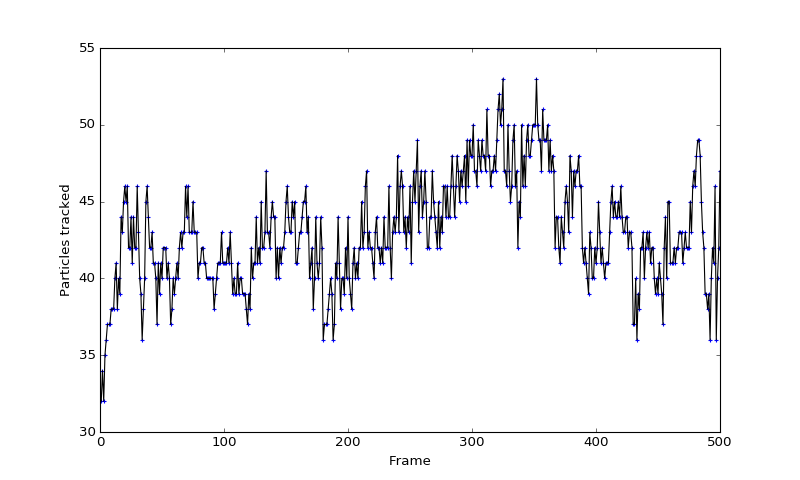

<IPython.core.display.Javascript object>


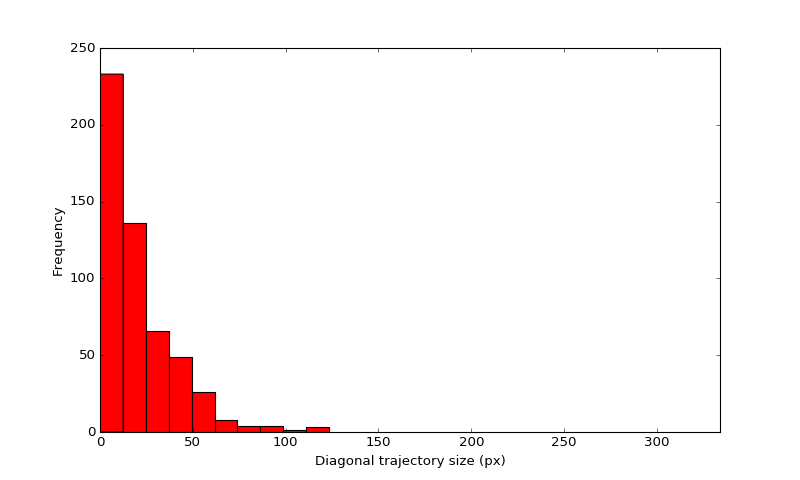

<IPython.core.display.Javascript object>


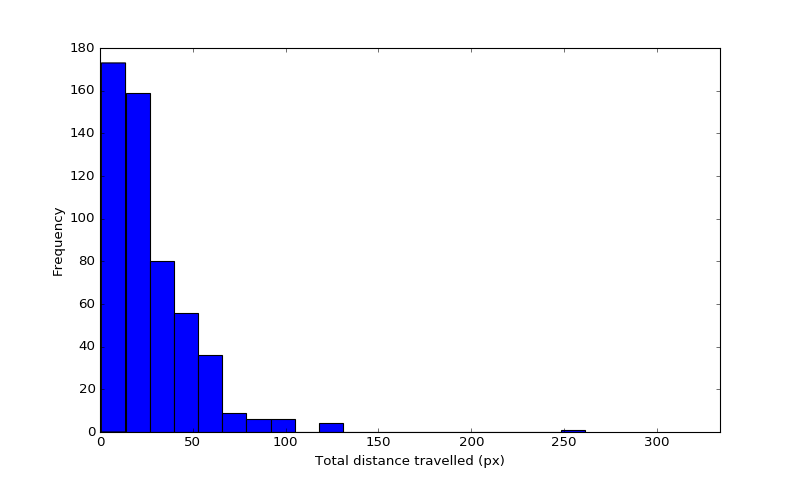

<IPython.core.display.Javascript object>


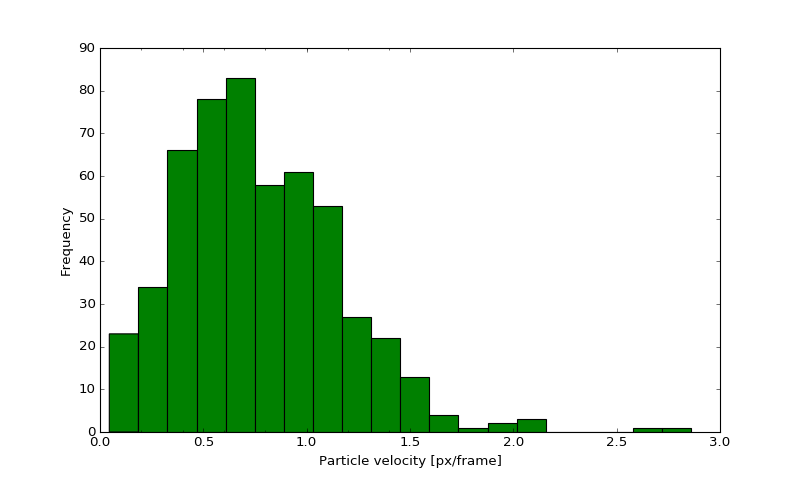

In [65]:
#particle tracking statistics
basename = resultsdir + '\\' + filename[:-4] +'_'

#Number of tracked blood cells per frame
fnumbers = trajsF1['frame'].unique()
PartPerFrame = [trajsF1[trajsF1['frame']==fnumbers[i]].shape[0] for i in fnumbers]
fx = np.arange(1,len(PartPerFrame)+1,1)
plt.figure()
ax0=plt.axes()
ax0.scatter(x=fx, y=PartPerFrame, s=20, marker='+', linewidths=1)
PartLine = mpl.lines.Line2D(xdata=fx,ydata=PartPerFrame, linewidth=1, color='black')
ax0.add_line(PartLine)
ax0.axis(xmin=0, xmax=len(frames))
ax0.set_xlabel('Frame')
ax0.set_ylabel('Particles tracked')
plt.savefig(basename + 'CellsPerFrame')

#hist: Diagonal trajectory size
plt.figure('Diagonal trajectory sizes')
ax1=plt.axes()
maxdist = np.floor(np.linalg.norm(frames[0].shape)) # diagonal image size
ax1.hist(p_parms[:,1], histtype='bar', color='red', bins=10)
ax1.axis(xmin=0, xmax=maxdist)
ax1.set_xlabel('Diagonal trajectory size (px)')
ax1.set_ylabel('Frequency')
plt.savefig(basename + 'DiagSize')

#hist: Total distance travelled
plt.figure('Total distance tracked')
ax2=plt.axes()
ax2.hist(p_parms[:,2], histtype='bar', color='blue', bins=20)
ax2.axis(xmin=0, xmax=maxdist)
ax2.set_xlabel('Total distance travelled (px)')
ax2.set_ylabel('Frequency')

#hist Mean particle velocity
plt.figure('Mean particle velocity')
ax3=plt.axes()
ax3.hist(p_parms[:,3], histtype='bar', color='green', bins=20)
#ax3.axis(xmin=0, xmax=2)
ax3.set_xticks(np.arange(0,1.5,0.2), minor=True)
ax3.set_xlabel('Particle velocity [px/frame]')
ax3.set_ylabel('Frequency')

#Particle velocity as a function of distance travelled
#Does the tracked distance matter for the velocity calculation?




In [135]:
np.arange(0,2,0.5)

array([ 0. ,  0.5,  1. ,  1.5])